# Getting started with Owl-ViT

In this notebook, we are going to run the [OWL-ViT](https://arxiv.org/abs/2205.06230) model (an open-vocabulary object detection model) by Google Research on scikit-image samples images. 

## OWL-ViT: A Quick Intro
OWL-ViT is an open-vocabulary object detector. Given an image and one or multiple free-text queries, it finds objects matching the queries in the image. Unlike traditional object detection models, OWL-ViT is not trained on labeled object datasets and leverages multi-modal representations to perform open-vocabulary detection. 

OWL-ViT uses CLIP with a ViT-like Transformer as its backbone to get multi-modal visual and text features. To use CLIP for object detection, OWL-ViT removes the final token pooling layer of the vision model and attaches a lightweight classification and box head to each transformer output token. Open-vocabulary classification is enabled by replacing the fixed classification layer weights with the class-name embeddings obtained from the text model. The authors first train CLIP from scratch and fine-tune it end-to-end with the classification and box heads on standard detection datasets using a bipartite matching loss. One or multiple text queries per image can be used to perform zero-shot text-conditioned object detection.

![owlvit architecture](https://raw.githubusercontent.com/google-research/scenic/a41d24676f64a2158bfcd7cb79b0a87673aa875b/scenic/projects/owl_vit/data/owl_vit_schematic.png)

## Set-up environment

First, we install the HuggingFace Transformers library (from source for now, as the model was just added to the library and not yet included in a new PyPi release). This might take a few minutes.

In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install Pillow
!pip install matplotlib
!pip install opencv-python

## Load pre-trained model and processor

Let's first apply the image preprocessing and tokenize the text queries using `OwlViTProcessor`. The processor will resize the image(s), scale it between [0-1] range and normalize it across the channels using the mean and standard deviation specified in the original codebase.


Text queries are tokenized using a CLIP tokenizer and stacked to output tensors of shape [batch_size * num_max_text_queries, sequence_length]. If you are inputting more than one set of (image, text prompt/s), num_max_text_queries is the maximum number of text queries per image across the batch. Input samples with fewer text queries are padded. 

In [15]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

## Preprocess input image and text queries

Let's use the image of astronaut Eileen Collins to test OWL-ViT. It's part of the [NASA](https://www.nasa.gov/multimedia/imagegallery/index.html) Great Images dataset.

You can use one or multiple text prompts per image to search for the target object(s). Let's start with a simple example where we search for multiple objects in a single image.

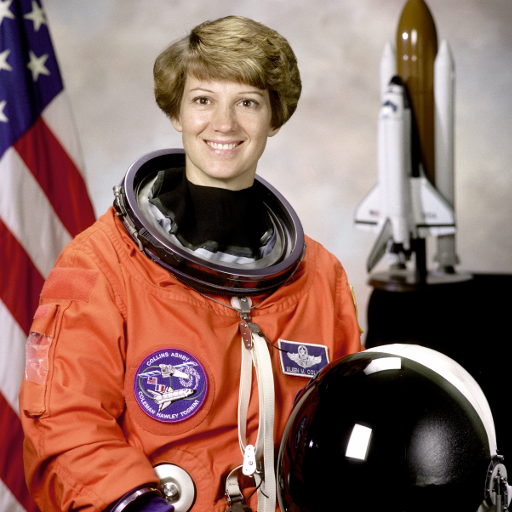

In [16]:
import skimage
import numpy as np
from PIL import Image

# Download sample image
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

# Text queries to search the image for
text_queries = ["human face", "rocket", "nasa badge", "star-spangled banner"]

image

In [17]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [18]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 768, 768])


## Forward pass

Now we can pass the inputs to our OWL-ViT model to get object detection predictions. 

`OwlViTForObjectDetection` model outputs the prediction logits, boundary boxes and class embeddings, along with the image and text embeddings outputted by the `OwlViTModel`, which is the CLIP backbone.

In [19]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 4])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 4, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])
text_model_last_hidden_state: shape of torch.Size([4, 16, 512])
vision_model_last_hidden_state: shape of torch.Size([1, 577, 768])


## Draw predictions on image

Let's draw the predictions / found objects on the input image. Remember the found objects correspond to the input text queries. 

In [20]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

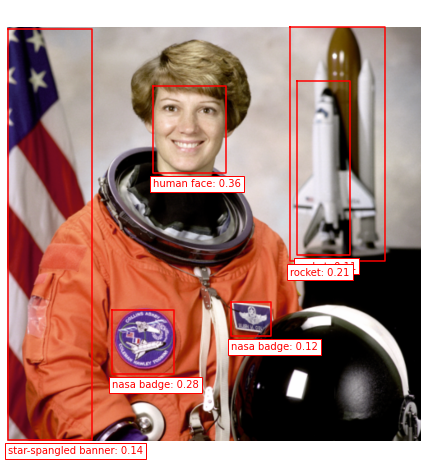

In [21]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
    
plot_predictions(input_image, text_queries, scores, boxes, labels)

## Batch processing
We can also pass in multiple sets of images and text queries to search for different (or same) objects in different images. Let's download an image of a coffee mug to process alongside the astronaut image.

For batch processing, we need to input text queries as a nested list to `OwlViTProcessor` and images as lists of (PIL images or PyTorch tensors or NumPy arrays).

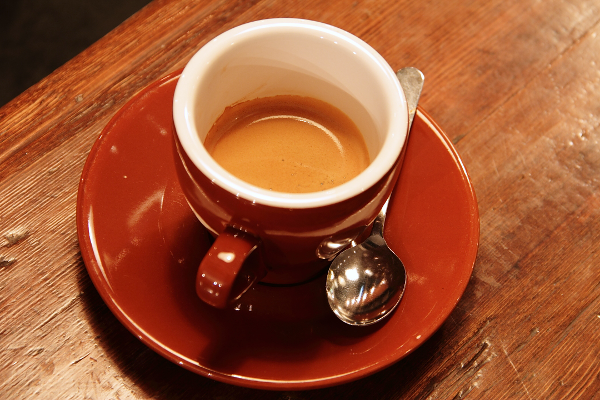

In [22]:
# Download the coffee mug image
image = skimage.data.coffee()
image = Image.fromarray(np.uint8(image)).convert("RGB")
image

In [23]:
# Preprocessing
images = [skimage.data.astronaut(), skimage.data.coffee()]
images = [Image.fromarray(np.uint8(img)).convert("RGB") for img in images]

# Nexted list of text queries to search each image for
text_queries = [["human face", "rocket", "nasa badge", "star-spangled banner"], ["coffee mug", "spoon", "plate"]]

# Process image and text inputs
inputs = processor(text=text_queries, images=images, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([8, 16])
attention_mask: torch.Size([8, 16])
pixel_values: torch.Size([2, 3, 768, 768])


**Note:** Notice the size of the `input_ids `and `attention_mask` is `[batch_size * num_max_text_queries, max_length]`. Max_length is set to 16 for all OWL-ViT models.

In [24]:
# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([2, 576, 4])
pred_boxes: shape of torch.Size([2, 576, 4])
text_embeds: shape of torch.Size([2, 4, 512])
image_embeds: shape of torch.Size([2, 24, 24, 768])
class_embeds: shape of torch.Size([2, 576, 512])
text_model_last_hidden_state: shape of torch.Size([8, 16, 512])
vision_model_last_hidden_state: shape of torch.Size([2, 577, 768])


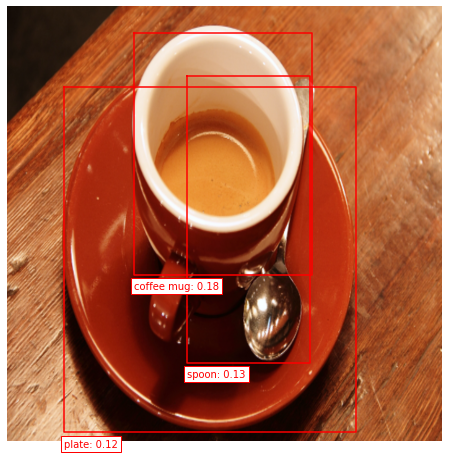

In [25]:
# Let's plot the predictions for the second image
image_idx = 1
image_size = model.config.vision_config.image_size
image = mixin.resize(images[image_idx], image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][image_idx], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][image_idx].cpu().detach().numpy()

plot_predictions(input_image, text_queries[image_idx], scores, boxes, labels)

## Post-processing model predictions
Notice how we printed the output predictions on the resizd input image. This is because OWL-ViT outputs normalized box coordinates in `[cx, cy, w, h]` format assuming a fixed input image size. We can use the `OwlViTProcessor`'s convenient post_process() method to convert the model outputs to a COCO API format and retrieve rescaled coordinates (with respect to the original image sizes) in `[x0, y0, x1, y1]` format. 

In [26]:
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([img.size[::-1] for img in images]).to(device)

# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

# Loop over predictions for each image in the batch
for i in range(len(images)):
    print(f"\nProcessing image {i}")
    text = text_queries[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    score_threshold = 0.1
    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]

        if score >= score_threshold:
            print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


Processing image 0
Detected human face with confidence 0.357 at location [180.23, 71.53, 271.25, 178.76]
Detected rocket with confidence 0.106 at location [358.81, 64.85, 424.18, 280.84]
Detected star-spangled banner with confidence 0.138 at location [1.43, 1.26, 105.38, 509.68]
Detected rocket with confidence 0.211 at location [350.98, -1.17, 468.6, 288.51]
Detected nasa badge with confidence 0.281 at location [129.58, 348.54, 206.46, 427.98]
Detected nasa badge with confidence 0.12 at location [277.15, 338.86, 327.42, 380.85]

Processing image 1
Detected coffee mug with confidence 0.175 at location [175.23, 24.72, 420.98, 246.83]
Detected spoon with confidence 0.132 at location [248.54, 63.72, 418.45, 327.98]
Detected plate with confidence 0.115 at location [78.9, 74.04, 481.06, 391.81]


## One-shot / image-guided object detection
Instead of performing zero-shot detection with text inputs, we can use a query / example image to find all instances of the query object in the input image. To do this, we simply pass in `query_images` instead of text to the processor to get the `query_pixel_values`. The output and post-processing of one-shot object detection is exactly the same as zero-shot / text-guided detection.

Let's try this out by querying an image with cats with another random cat image. For this part of the demo, we will perform image-guided object detection, post-process the results and print the predicted boundary boxes on the original input image.

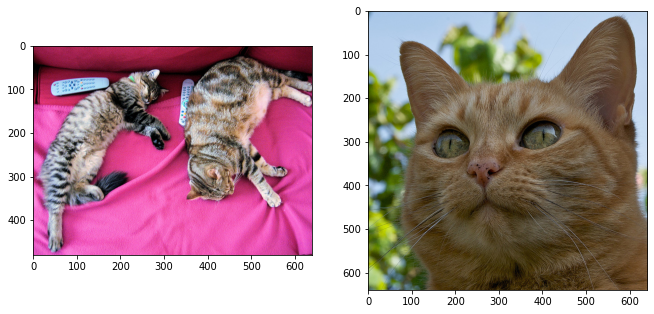

In [27]:
import requests
from matplotlib import rcParams

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Input image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Query image
query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(query_image)

In [28]:
# Process input and query image
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [29]:
# Get predictions
with torch.no_grad():
  outputs = model(**inputs, iou_threshold=0.6)

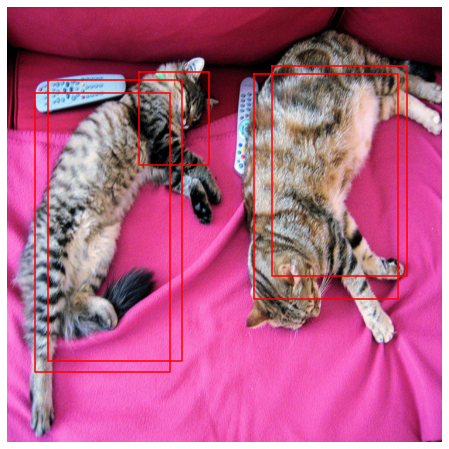

In [30]:
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.0001

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for score, box, label in zip(scores, boxes, labels):
  if score < score_threshold:
    continue

  cx, cy, w, h = box
  ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
          [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")